In [2]:
# #colabを使う方はこちらを使用ください。
# !pip install torch==0.4.1
# !pip install torchvision==0.2.1
# !pip install numpy==1.14.6
# !pip install matplotlib==2.1.2
# !pip install pillow==5.0.0
# !pip install opencv-python==3.4.3.18
# !pip install torchtext==0.3.1

    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x598c8000 @  0x7f36984d62a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 2.0MB 14.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.9MB 6.4MB/s 
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
    100% |████████████████████████████████| 25.0MB 1.8MB/s 
  Found existing installation: opencv-python 3.4.4.19
    Uninstalling opencv-python-3.4.4.19:
      Successfully uninstalle

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import time
import os

In [2]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

False


# 独自データセットを畳み込みニューラルネットで画像分類

## データの読み込み

In [3]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2023-02-12 23:34:05--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
download.pytorch.org (download.pytorch.org) をDNSに問いあわせています... 2600:9000:221a:f600:d:607e:4540:93a1, 2600:9000:221a:5200:d:607e:4540:93a1, 2600:9000:221a:b200:d:607e:4540:93a1, ...
download.pytorch.org (download.pytorch.org)|2600:9000:221a:f600:d:607e:4540:93a1|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 47286322 (45M) [application/zip]
`hymenoptera_data.zip' に保存中

hymenoptera_data.zi 100%[===================>]  45.10M  5.38MB/s    時間 7.8s    

2023-02-12 23:34:13 (5.82 MB/s) - `hymenoptera_data.zip' へ保存完了 [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_

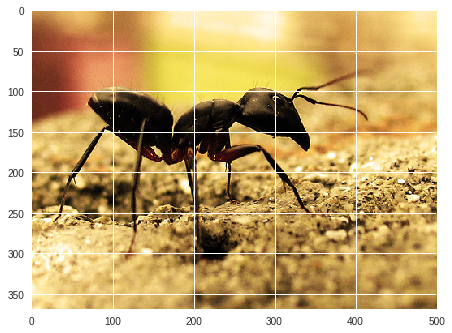

In [ ]:
import cv2
#画像の読み込み
img = cv2.imread('./hymenoptera_data/train/ants/649026570_e58656104b.jpg')
#画像のチャンネルをbgrからrgbに変換
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#画像を表示
plt.imshow(img)
plt.show()

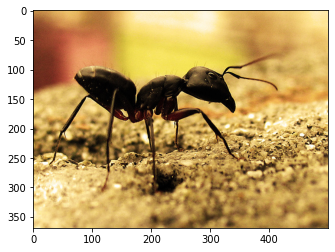

In [5]:
from PIL import Image
#画像の読み込み
image = "./hymenoptera_data/train/ants/649026570_e58656104b.jpg"
with open(image, 'rb') as f:
    image = Image.open(f)
    image = image.convert('RGB')
#画像を表示
plt.imshow(image)
plt.show()

In [6]:
#画像の前処理を定義
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}
#正規化をしない前処理
to_tensor_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

In [7]:
data_transforms["train"]

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [8]:
root = 'hymenoptera_data'
class CustomDataset(torch.utils.data.Dataset):  
    classes = ['ant', 'bee']
  
    def __init__(self, root, transform=None, train=True):
        # 指定する場合は前処理クラスを受け取ります。
        self.transform = transform
        # 画像とラベルの一覧を保持するリスト
        self.images = []
        self.labels = []
        # ルートフォルダーパス
        root = "hymenoptera_data"
        # 訓練の場合と検証の場合でフォルダわけ
        # 画像を読み込むファイルパスを取得します。
        if train == True:
            root_ants_path = os.path.join(root, 'train', 'ants')
            root_bees_path = os.path.join(root, 'train', 'bees')
        else:
            root_ants_path = os.path.join(root, 'val', 'ants')
            root_bees_path = os.path.join(root, 'val', 'bees')
        # アリの画像一覧を取得します。
        ant_images = os.listdir(root_ants_path)
        # ここではアリをラベル０に指定します。
        ant_labels = [0] * len(ant_images)
        # ハチの画像一覧を取得します。
        bee_images = os.listdir(root_bees_path)
        # ここではハチをラベル１に指定します。
        bee_labels = [1] * len(bee_images)
        # 1個のリストにします。
        for image, label in zip(ant_images, ant_labels):
            self.images.append(os.path.join(root_ants_path, image))
            self.labels.append(label)
        for image, label in zip(bee_images, bee_labels):
            self.images.append(os.path.join(root_bees_path, image))
            self.labels.append(label)
        
    def __getitem__(self, index):
        # インデックスを元に画像のファイルパスとラベルを取得します。
        image = self.images[index]
        label = self.labels[index]
        # 画像ファイルパスから画像を読み込みます。
        with open(image, 'rb') as f:
            image = Image.open(f)
            image = image.convert('RGB')
        # 前処理がある場合は前処理をいれます。
        if self.transform is not None:
            image = self.transform(image)
        # 画像とラベルのペアを返却します。
        return image, label
        
    def __len__(self):
        # ここにはデータ数を指定します。
        return len(self.images)


[1 0 0 0 1]


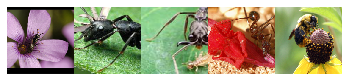

In [9]:
# 訓練データのプロット
custom_dataset = CustomDataset(root, to_tensor_transforms, train=True)
custom_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=5, 
                                           shuffle=True)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

for i, (images, labels) in enumerate(custom_loader):
    print(labels.numpy())
    show(torchvision.utils.make_grid(images, padding=1))
    plt.axis('off')
    
    break

[0 1 1 1 1]


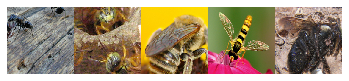

In [10]:
# テストデータのプロット
custom_dataset = CustomDataset(root, to_tensor_transforms)
custom_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=5, 
                                           shuffle=True)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

for i, (images, labels) in enumerate(custom_loader):
    print(labels.numpy())
    show(torchvision.utils.make_grid(images, padding=1))
    plt.axis('off')
    
    break

In [11]:
# 定義したDatasetとDataLoaderを使います。
custom_train_dataset = CustomDataset(root, data_transforms["train"], train=True)
train_loader = torch.utils.data.DataLoader(dataset=custom_train_dataset,
                                           batch_size=5, 
                                           shuffle=True)
custom_test_dataset = CustomDataset(root, data_transforms["val"], train=False)
test_loader = torch.utils.data.DataLoader(dataset=custom_test_dataset,
                                           batch_size=5, 
                                           shuffle=False)

for i, (images, labels) in enumerate(train_loader):
    print(images.size())
    print(images[0].size())    
    print(labels[0].item())
    #ここに訓練などの処理をきます。
    break

torch.Size([5, 3, 224, 224])
torch.Size([3, 224, 224])
0


## ネットワークの定義

In [12]:
#クラス数変更
num_classes = 2

class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), #padding=5から2に変更。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        #全結合部分の変更。
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

## 学習

In [13]:
#エラーになる例
num_epochs = 50

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

RuntimeError: size mismatch, m1: [5 x 9216], m2: [256 x 4096] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:2070

In [14]:
#全結合の次元を計算
size_check = torch.FloatTensor(10, 3, 224, 224)
features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
#バッチサイズ10, 6×6のフィルターが256枚
#10バッチは残して、6×6×256を１次元に落とす=>6×6×256=9216
print(features(size_check).size())
#バッチ１０の値を軸にして残りの次元を１次元へ落とした場合のTensorの形状をチェックすると9216。
print(features(size_check).view(size_check.size(0), -1).size())
#fc_sizeを全結合の形状として保持しておく
fc_size = features(size_check).view(size_check.size(0), -1).size()[1]
print(fc_size)

torch.Size([10, 256, 6, 6])
torch.Size([10, 9216])
9216


In [15]:
num_classes = 2

class AlexNet(nn.Module):
    #fc_sizeを引き渡す
    def __init__(self, num_classes, fc_size):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        #fc_sizeで計算した形状を指定
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(fc_size, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes, fc_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [16]:
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [17]:
num_epochs = 100

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/100], Loss: 0.1390, val_loss: 0.1405, val_acc: 0.4575
Epoch [2/100], Loss: 0.1391, val_loss: 0.1411, val_acc: 0.4575
Epoch [3/100], Loss: 0.1391, val_loss: 0.1385, val_acc: 0.5425
Epoch [4/100], Loss: 0.1385, val_loss: 0.1425, val_acc: 0.4575
Epoch [5/100], Loss: 0.1399, val_loss: 0.1416, val_acc: 0.4575
Epoch [6/100], Loss: 0.1410, val_loss: 0.1445, val_acc: 0.4575
Epoch [7/100], Loss: 0.1391, val_loss: 0.1401, val_acc: 0.5425
Epoch [8/100], Loss: 0.1392, val_loss: 0.1402, val_acc: 0.5425
Epoch [9/100], Loss: 0.1390, val_loss: 0.1411, val_acc: 0.4575
Epoch [10/100], Loss: 0.1390, val_loss: 0.1398, val_acc: 0.5425
Epoch [11/100], Loss: 0.1388, val_loss: 0.1400, val_acc: 0.5817
Epoch [12/100], Loss: 0.1379, val_loss: 0.1377, val_acc: 0.5490
Epoch [13/100], Loss: 0.1368, val_loss: 0.1355, val_acc: 0.5490
Epoch [14/100], Loss: 0.1338, val_loss: 0.1358, val_acc: 0.5948
Epoch [15/100], Loss: 0.1362, val_loss: 0.1516, val_acc: 0.5752
Epoch [16/100], Loss: 0.1341, val_loss: 0.1377, v

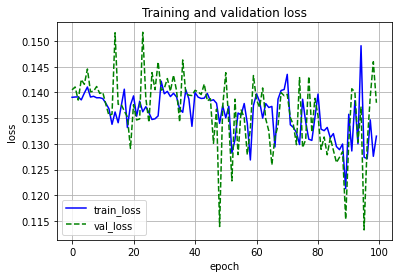

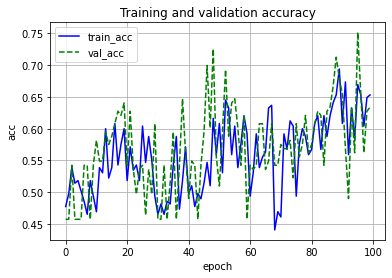

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## ImageFolderを使用する

In [19]:
#画像とラベルを読み込む
data_dir = 'hymenoptera_data'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                     data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                   data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5,
                                             shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5,
                                             shuffle=False, num_workers=4)

In [20]:
for train in train_loader:
    print(train[0].shape)
    print(train[0].dtype)
    break

torch.Size([5, 3, 224, 224])
torch.float32
